In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)
sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

### Load the ground-truth and evaluate the methods

In [2]:
from intestine_info import load_processed_enterocyte_data, load_original_entero_zonation
from intestine_info import get_intestine_rna_lm_genes
from io_utils import load_all_pipeline_results
from plot_utils import plot_corr_mtx
from scrna_utils import get_gene_df
from general_utils import rank_and_bin

res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
zone_vals = load_original_entero_zonation(just_vals=True)
obs_df, var_df, mtx = load_processed_enterocyte_data(res_dir)
RDIR = os.path.join(res_dir, "entero_data", "results")
pipe_res, all_lams = load_all_pipeline_results(RDIR)
print('Matrix dimension: {}'.format(mtx.shape))
display(pipe_res.keys())
display(all_lams.keys())

[feat_viz INFO] {'Crypt': 0, 'V1': 1, 'V2': 2, 'V3': 3, 'V4': 4, 'V5': 5, 'V6': 6}
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_pc_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_graph_oracle.plk does not exist
[feat_viz WARNING] /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/results/result_hybrid_oracle.plk does not exist


Matrix dimension: (1383, 9656)


dict_keys(['pc_vanilla', 'graph_vanilla', 'hybrid_vanilla'])

dict_keys(['unsup_graph', 'unsup_pc'])

In [3]:
obs_df.head()

,n_genes,n_counts,cell_id
0,2033,6751.0,AAACCTGGTAAGTTCC
1,1135,3754.0,AAACGGGCACCAACCG
2,2559,9224.0,AAACGGGTCACTGGGC
3,1706,5144.0,AAAGATGGTGGACGAT
4,3079,11475.0,AAAGATGGTTCGGGCT


### Compare all lambdas if needed

In [4]:
lm_genes = get_intestine_rna_lm_genes()
lm_genes = lm_genes["high"] + lm_genes["low"]
logger.info("Number of original lm genes: {}".format(len(lm_genes)))
lm_genes = list(set(lm_genes).intersection(set(var_df["gene_ids"])))
lm_genes = sorted(lm_genes)
logger.info("Number of intersecting lm genes: {}".format(len(lm_genes)))

[feat_viz INFO] Loaded 453 genes
[feat_viz INFO] Kept 243 genes with max expr > 0.001 
[feat_viz INFO] Kept 45 high zone genes with geom avg > 3.5 
[feat_viz INFO] Kept 64 low zone genes with geom avg < 2.5 
[feat_viz INFO] Number of original lm genes: 109
[feat_viz INFO] Number of intersecting lm genes: 97


palantir
paga


[feat_viz INFO] Saved figure to: /scratch/users/jjzhu/tmp_fig/entero_hm.pdf


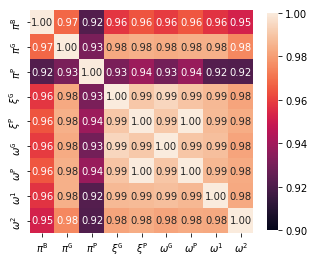

In [5]:
all_lams["smFISH"] = zone_vals
mopts = ["graph", "pc", "hybrid"]
mtypes = ["vanilla"]
for method in mopts:
    for mtype in mtypes:
        key = "{}_{}".format(method, mtype)
        result = pipe_res[key] 
        for lam_t in ["lam_init", "lam_update"]:
            name = "{}_{}".format(key, lam_t)
            all_lams[name] = result[lam_t]
# add lambdas from ti methods
mdir = '/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/ti_methods'
names = ['palantir', 'paga']
for name in names:
    fn = os.path.join(mdir, '{}_obs_df.csv'.format(name))
    df = pd.read_csv(fn)
    df = df.set_index('cell_id')
    df = df.loc[obs_df['cell_id']]
    print(name)
    all_lams[name] = df['pseudotime']

lam_df = pd.DataFrame(all_lams)
# manually switch signs
switch_signs = ["graph_vanilla_lam_init", 
                "graph_vanilla_lam_update",
                "pc_vanilla_lam_update",
                "unsup_graph",
                "unsup_pc"]
for var in switch_signs:
    lam_df[var] = - lam_df[var]
# select and rename here

methods = ["smFISH", 
           "graph_vanilla_lam_init", 
           "pc_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "pc_vanilla_lam_update",
           "unsup_graph",
           "unsup_pc",
           "palantir", 
           "paga"]
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
    "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
    "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
    "unsup_graph": r"$\omega^\mathtt{G}$",
    "unsup_pc": r"$\omega^\mathtt{P}$",
    "palantir": r"$\omega^\mathtt{1}$",
    "paga" : r"$\omega^\mathtt{2}$",
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
sub_df.head()

fn = '/scratch/users/jjzhu/tmp_fig/entero_hm.pdf'
plot_corr_mtx(sub_df, vmin=0.9, fn=fn)
# save the lambdas to file
# sub_df.to_csv("~/lambdas.csv", index=False)

In [8]:
# load the sets from table
dat_dir = "/share/PI/sabatti/sc_data/intestine2k"
fn = os.path.join(dat_dir, "table_D_zonation_reconstruction.tsv")
tab_d_df = pd.read_table(fn, delimiter="\t").dropna()
tab_d_df = tab_d_df.set_index('Gene name')
tab_d_df = tab_d_df.reindex(var_df.gene_ids)
n_genes = var_df.shape[0]
assert tab_d_df.shape[0] == n_genes, 'number of gene mismatch'
print('Number of genes: {}'.format(n_genes))
threshold = 0.05
sub_d_df = tab_d_df.loc[tab_d_df['qval'] < 0.05]
n_sel_genes = sub_d_df.shape[0]
print('original : {} ({:.4f}%)'.format(n_sel_genes, n_sel_genes/n_genes*100))

Number of genes: 9656
original : 7946 (82.2908%)


In [10]:
# (alternatively) load the genes used for k-means clustering
fn =  os.path.join(dat_dir, "extracted", "kmeans_meta.csv")
kdf = pd.read_csv(fn)
kdf.head()

,gene_name,indin,clust_idx
0,Mrpl15,8,1
1,Lypla1,9,3
2,Arfgef1,40,3
3,Tram1,52,1
4,Rpl7,63,4


In [16]:
# look at the intersection between the three methods
gset = {}
gset['original'] = set(sub_d_df.index)
gset['cluster'] = set(kdf.gene_name)

In [17]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


In [18]:
from main_methods import setup_cmp_df
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(pipe_res)
for i, met in enumerate(mets[:2]):
    gset[met] = set(var_df['gene_ids'][cmp_sets[i]])

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] hybrid_vanilla threshold: 0.0273


original : 7946 (82.2908)%
cluster : 2118 (21.9345)%
pc_vanilla : 7747 (80.2299)%
graph_vanilla : 6892 (71.3753)%


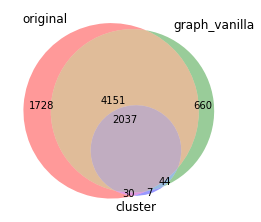

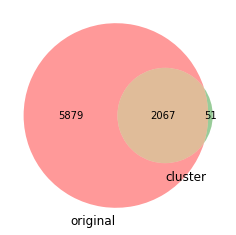

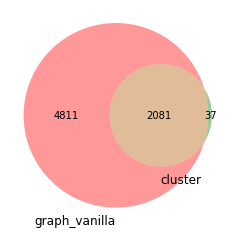

[feat_viz INFO] Saved figure to: /scratch/users/jjzhu/tmp_fig/entero_venn.pdf


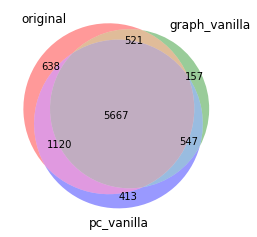

In [28]:
from plot_utils import plot_venn
for met in gset:
    n_sel_genes = len(gset[met])
    print('{} : {} ({:.4f})%'.format(met, n_sel_genes, n_sel_genes/n_genes*100))
plot_venn(gset, ['original', 'graph_vanilla', 'cluster'])
plot_venn(gset, ['original', 'cluster'])
plot_venn(gset, ['graph_vanilla', 'cluster'])
plot_venn(gset, ['original', 'graph_vanilla', 'pc_vanilla'], fn='/scratch/users/jjzhu/tmp_fig/entero_venn.pdf')

In [80]:
keys

['original', 'pc_vanilla', 'graph_vanilla']

In [59]:
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        m1 = keys[i]
        m2 = keys[j]
        cap = vals[i].intersection(vals[j])
        cup = vals[i].union(vals[j])
        score = len(cap) / len(cup)
        print('{} vs {}: {}'.format(m1, m2, score))

original vs pc_vanilla: 0.7620705142600495
original vs graph_vanilla: 0.7153757225433526
pc_vanilla vs graph_vanilla: 0.737566765578635


[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355


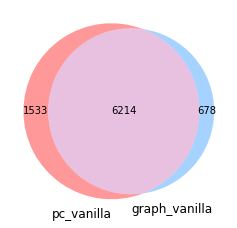

In [5]:
from plot_utils import plot_and_compare_results
def compare_methods(res, mlist):
    cmp_methods = {}
    for m in mlist:
        assert m in res, "{} not found".format(m)
        cmp_methods[m] = res[m]
    plot_and_compare_results(cmp_methods)
compare_methods(pipe_res, ["pc_vanilla", "graph_vanilla"])

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] hybrid_vanilla threshold: 0.0273


In [16]:
var_df.head()

,gene_ids,n_cells,mean,std,npc
0,Mrpl15,530,0.386412,0.530710,530
1,Lypla1,1045,0.999767,0.698513,1045
2,Tcea1,367,0.225788,0.401705,367
3,Atp6v1h,171,0.101006,0.292252,171
4,Rb1cc1,340,0.220587,0.425791,340


In [10]:
pval_df.shape

(9656, 3)

pc_vanilla : 80.2299%
graph_vanilla : 71.3753%
hybrid_vanilla : 54.7742%


In [7]:
pipe_res

{'pc_vanilla': {'lam_init': array([-0.44025642,  5.4823265 , -7.28304   , ...,  3.9972103 ,
          3.1224914 , -6.32924   ], dtype=float32),
  'lam_update': array([ -9.970622, -20.481222,  19.689318, ..., -21.882849, -20.019737,
          20.451033], dtype=float32),
  'p_vals': array([9.99900010e-05, 9.99900010e-05, 9.99900010e-05, ...,
         7.77622238e-01, 5.93540646e-01, 3.99960004e-04]),
  'rejections': array([   0,    1,    2, ..., 9650, 9651, 9655])},
 'graph_vanilla': {'lam_init': array([-0.01300048, -0.02191447,  0.02364276, ..., -0.02104047,
         -0.01932365,  0.03370192]),
  'lam_update': array([-0.01136195, -0.01989204,  0.01827042, ..., -0.02045793,
         -0.02009152,  0.02030101]),
  'p_vals': array([9.99900010e-05, 9.99900010e-05, 9.99900010e-05, ...,
         7.27527247e-01, 4.39956004e-03, 3.57964204e-02]),
  'rejections': array([   0,    1,    2, ..., 9649, 9650, 9654])},
 'hybrid_vanilla': {'lam_init': array([-0.44025642,  5.4823265 , -7.28304   , ...,  3

### Search for p-values of known genes

In [6]:
from main_methods import setup_cmp_df, get_unique_rejection_df
from plot_utils import create_color_map, plot_full_pattern
from matplotlib.ticker import FormatStrFormatter
from plot_utils import update_boxplot_cols
from plot_utils import plot_gene_expr_comp
from scrna_utils import get_gene_df

cmp_methods = {key: pipe_res[key] for key in ["pc_vanilla", "graph_vanilla"]}
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(cmp_methods)
pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
unique_dict, unique_df = get_unique_rejection_df(cmp_methods, var_df)
unique_glist = {}
top_k = 10
for key in cmp_methods:
    unique_glist[key] = list(unique_dict[key].index[:top_k])
#     display(unique_dict[key].head(top_k))
display(unique_df.head())

[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] pc_vanilla threshold: 0.0401
[feat_viz INFO] graph_vanilla threshold: 0.0355
[feat_viz INFO] Set selection: (1533, 8)
[feat_viz INFO] Set selection: (678, 8)


,n_cells,mean,std,npc,pc_vanilla,graph_vanilla,exclusive_rejection
gene_ids,,,,,,,
Gm4262,13,0.011172,0.118423,13,0.0001,0.996200,pc_vanilla
Dhdds,123,0.066306,0.225791,123,0.0001,0.953905,pc_vanilla
Cbr4,69,0.035134,0.160391,69,0.0001,0.941406,pc_vanilla
Coq3,66,0.032493,0.150676,66,0.0001,0.938006,pc_vanilla
Prorsd1,163,0.092856,0.270002,163,0.0001,0.936406,pc_vanilla


In [30]:
def report_gene_info(report_genes):
    for gene in report_genes:
        if gene in unique_df.index:
            gene_info = unique_df.loc[gene]
            logger.info("{} only rejected by {}".format(gene, gene_info["exclusive_rejection"]))
    display(pval_df[pval_df["gene_ids"].isin(report_genes)].head(5))

def plot_gene_expression(genes, horizontal=False):
    gene_df = get_gene_df(genes, var_df, mtx)
#     report_gene_info(genes)
    plot_gene_expr_comp(lam_df, gene_df, methods, select_vars, horizontal=horizontal)
    
fn = "/share/PI/sabatti/sc_data/intestine2k/extracted/smFISH_genes.csv"
smFISH_genes = list(pd.read_csv(fn, header=None)[0])
logger.info("Number of original smFISH genes: {}".format(len(smFISH_genes)))
smFISH_genes = list(set(smFISH_genes).intersection(set(var_df["gene_ids"])))
smFISH_genes = sorted(smFISH_genes)
logger.info("Number of intersecting smFISH genes: {}".format(len(smFISH_genes)))
report_gene_info(smFISH_genes)   

graph_top_uniq_genes = unique_glist["graph_vanilla"][:8]
report_gene_info(graph_top_uniq_genes)   

[feat_viz INFO] Number of original smFISH genes: 23
[feat_viz INFO] Number of intersecting smFISH genes: 22
[feat_viz INFO] Cdh1 only rejected by graph_vanilla


,gene_ids,n_cells,mean,std,npc,pc_vanilla,graph_vanilla
149,Cps1,624,0.674070,0.844695,624,0.0001,0.0001
310,Pigr,1284,2.565508,0.998651,1284,0.0001,0.0001
987,Slc28a2,258,0.406770,0.986160,258,0.0001,0.0001
1196,Ada,716,1.053582,1.464546,716,0.0001,0.0001
1583,Slc2a2,650,0.663044,0.774591,650,0.0001,0.0001


[feat_viz INFO] Cyp4f14 only rejected by graph_vanilla
[feat_viz INFO] Aoc1 only rejected by graph_vanilla
[feat_viz INFO] Acbd4 only rejected by graph_vanilla
[feat_viz INFO] Eif4ebp1 only rejected by graph_vanilla
[feat_viz INFO] Agmo only rejected by graph_vanilla
[feat_viz INFO] Otop3 only rejected by graph_vanilla
[feat_viz INFO] Tcn2 only rejected by graph_vanilla
[feat_viz INFO] Sec23a only rejected by graph_vanilla


,gene_ids,n_cells,mean,std,npc,pc_vanilla,graph_vanilla
3424,Aoc1,990,1.016379,0.773854,990,0.990301,0.0001
5056,Eif4ebp1,203,0.121197,0.315728,203,0.977202,0.0001
6366,Tcn2,937,0.894356,0.739364,937,0.947905,0.0001
6987,Acbd4,858,0.729065,0.659869,858,0.982502,0.0001
7043,Otop3,138,0.100307,0.318529,138,0.960904,0.0001
